# Membaca Input Dataset dari Kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/padi-test/padi-bercak.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109165822_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109182447_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109211215_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109211710_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109211457_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109212113_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109165354_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109204037_00.jpg
/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast/IMG20201109182221_00.j

# Import Libraries

In [2]:
import os, shutil
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
!pip install tensorflowjs

2025-06-03 16:44:43.032073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748969083.210577      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748969083.269822      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [3]:
import tensorflowjs as tfjs

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preparation

### Fungsi untuk mengubah string menjadi snake_case

In [ ]:
def to_snake_case(name):
    name = name.strip().lower()
    name = re.sub(r'[\s\-]+', '_', name)
    name = re.sub(r'[^a-z0-9_]', '', name)
    name = re.sub(r'__+', '_', name)
    return name

### Fungsi untuk Standarisasi dan Menyalin Folder Dataset

In [ ]:
def standardize_folders(input_base_dir, output_base_dir):
    print(f"Memproses input direktori: {input_base_dir}")
    print(f"Output akan disimpan di: {output_base_dir}")

    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)
        print(f"Membuat direktori output utama: {output_base_dir}")

    original_folders = [f for f in os.listdir(input_base_dir) if os.path.isdir(os.path.join(input_base_dir, f))]
    
    mapping = {}
    for folder_name in original_folders:
        standardized_name = to_snake_case(folder_name)
        mapping[folder_name] = standardized_name

    for original_name, std_name in mapping.items():
        original_path = os.path.join(input_base_dir, original_name)
        std_path = os.path.join(output_base_dir, std_name)

        print(f"  Folder asli: {original_name} -> Path standar: {std_path}")

        if not os.path.exists(std_path):
            os.makedirs(std_path)
            print(f"    Membuat direktori standar: {std_path}")
        else:
            print(f"    Direktori standar sudah ada: {std_path}")

        print(f"    Menyalin file dari {original_path} ke {std_path}...")
        for filename in os.listdir(original_path):
            src_file = os.path.join(original_path, filename)
            dst_file = os.path.join(std_path, filename)
            
            if os.path.isfile(src_file):
                shutil.copy2(src_file, dst_file)
        print(f"    Selesai menyalin file untuk {original_name}.")
        
    print(f"Selesai memproses {input_base_dir}\n")

### Fungsi untuk membuat dataframe gambar dan label

In [ ]:
def prepare_dataframe(base_dir):
    data = []
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_full_path = os.path.join(label_path, file)
                    data.append((img_full_path, label))
    df = pd.DataFrame(data, columns=['img_path', 'label'])
    return df

### Fungsi untuk menyalin file gambar ke direktori

In [ ]:
def copy_files_to_dir(df, dest_dir):
    for _, row in df.iterrows():
        label_dir = os.path.join(dest_dir, row['label'])
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        src = row['img_path']
        dst = os.path.join(label_dir, os.path.basename(src))
        if os.path.exists(src):
             if not os.path.exists(dst):
                shutil.copy2(src, dst)
        else:
            print(f"Warning: Source file not found - {src}")

### Menghitung total file gambar dataset

In [6]:
train_dir = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/train'
test_dir = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test'

def count_total_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_files += len(image_files)
    return total_files

total_train_files = count_total_files(train_dir)
total_test_files = count_total_files(test_dir)

print(f"Total file gambar di data train: {total_train_files} file")
print(f"Total file gambar di data test: {total_test_files} file")

Total file gambar di data train: 15023 file
Total file gambar di data test: 3422 file


### Menampilkan contoh gambar per kelas

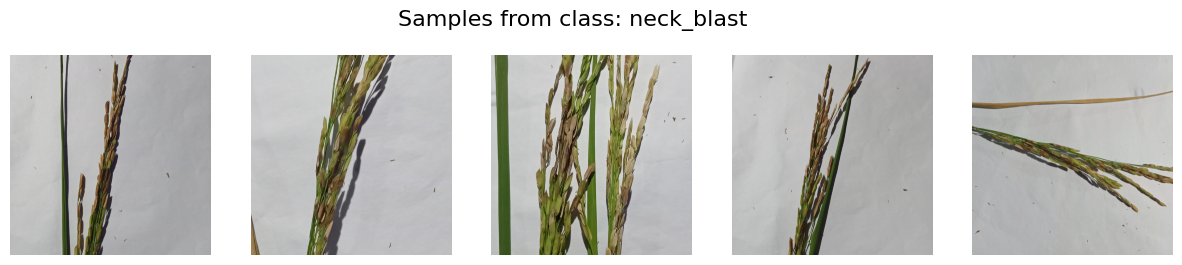

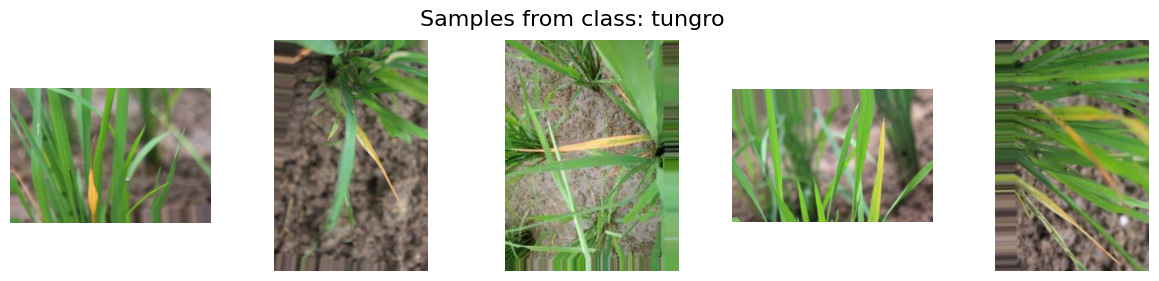

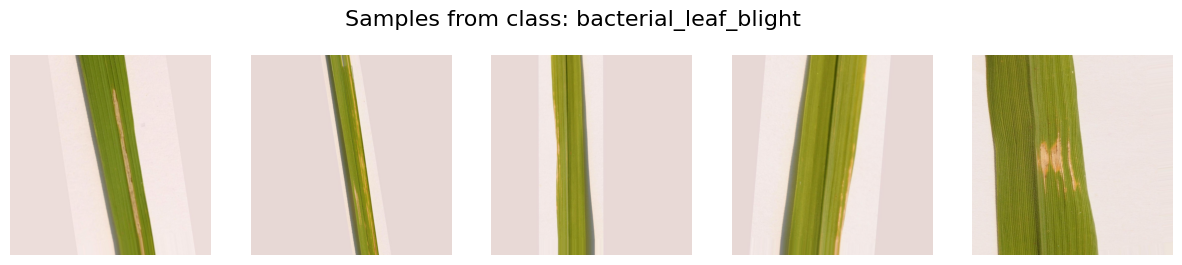

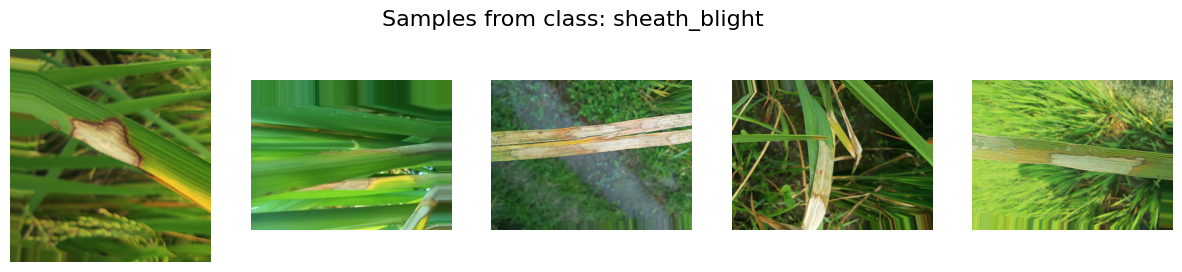

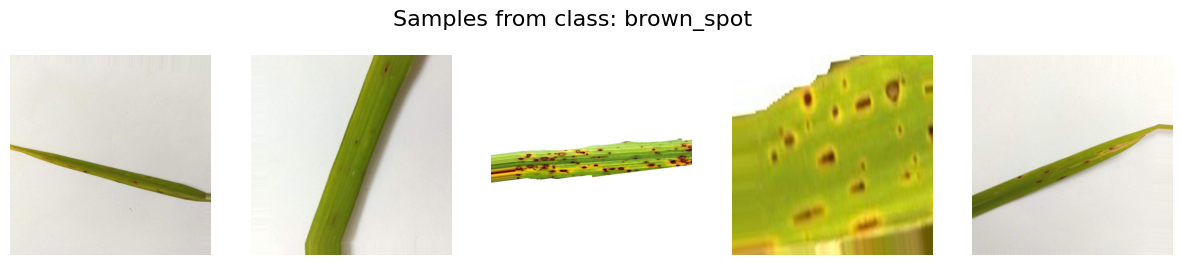

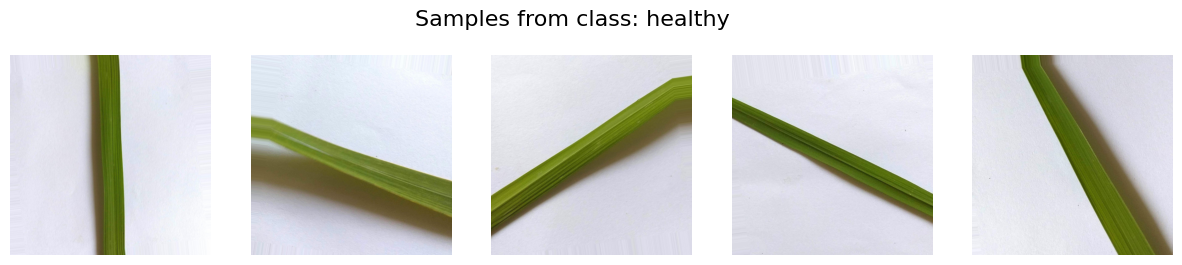

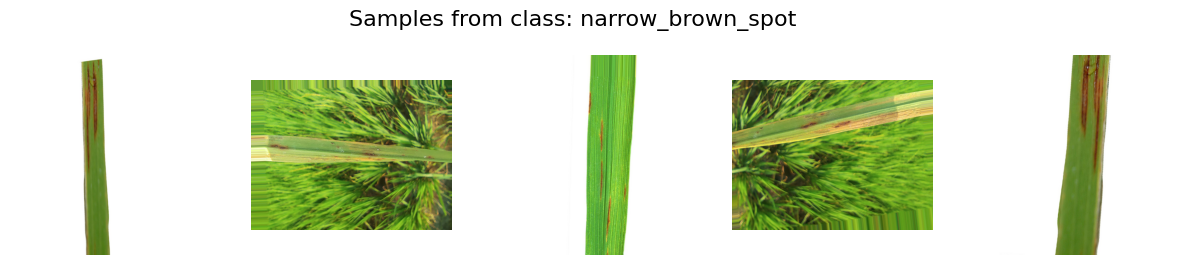

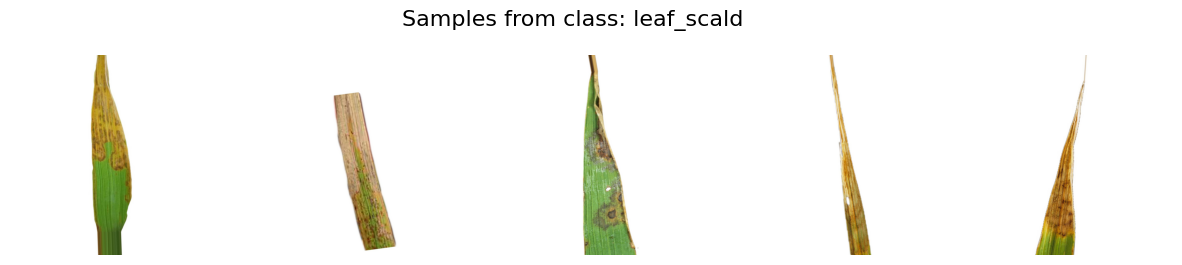

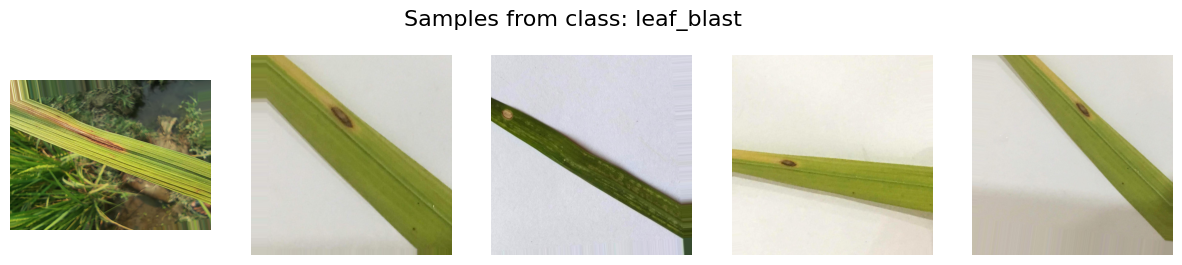

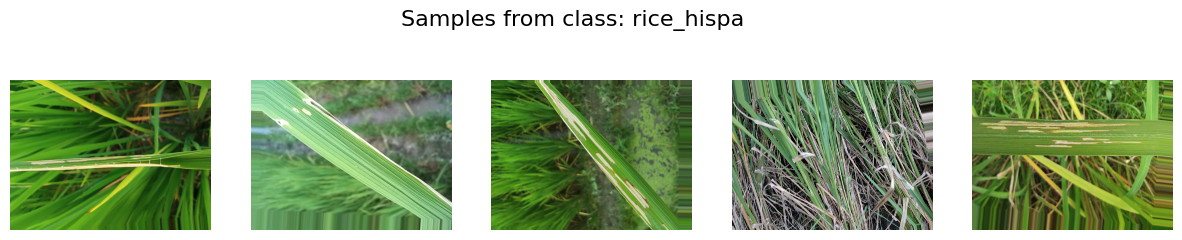

In [7]:
def show_sample_images_per_class(base_dir, samples_per_class=5):
    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        sample_files = random.sample(image_files, min(samples_per_class, len(image_files)))

        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Samples from class: {class_name}', fontsize=16)
        for i, img_file in enumerate(sample_files):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path)
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

show_sample_images_per_class(train_dir, samples_per_class=5)

### Membuat path direktori output dataset

In [8]:
main_output_directory = '/kaggle/working/rice_leaf_data_standardized'

# 2. Buat sub-direktori di dalam main_output_directory untuk setiap dataset jika diperlukan
output_aug_path = os.path.join(main_output_directory, 'Rice_Leaf_AUG_std')
output_test_path = os.path.join(main_output_directory, 'test_std')
output_train_path = os.path.join(main_output_directory, 'train_std')

### Menstandarkan dan menyalin folder dataset

In [9]:
standardize_folders(
    '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG',
    output_aug_path
)
standardize_folders(
    '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test',
    output_test_path
)
standardize_folders(
    '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/train',
    output_train_path
)

Memproses input direktori: /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG
Output akan disimpan di: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std
Membuat direktori output utama: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std
  Folder asli: Neck_Blast -> Path standar: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std/neck_blast
    Membuat direktori standar: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std/neck_blast
    Menyalin file dari /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Neck_Blast ke /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std/neck_blast...
    Selesai menyalin file untuk Neck_Blast.
  Folder asli: Leaf scald -> Path standar: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std/leaf_scald
    Membuat direktori standar: /kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std/leaf_scald
    Menyalin file dari /kaggle/input/rice-leaf-diseas

### Menggunakan Folder AUG untuk dataset juga

In [ ]:
aug_path = '/kaggle/working/rice_leaf_data_standardized/Rice_Leaf_AUG_std'
aug_df = prepare_dataframe(aug_path)

aug_df['label'] = aug_df['label'].replace({
    'narrow_brown_leaf_spot': 'narrow_brown_spot',
    'healthy_rice_leaf': 'healthy'
})

print("Sample paths in aug_df after standardizing and renaming:")
print(aug_df['img_path'].head())

Sample paths in aug_df after standardizing and renaming:
0    /kaggle/working/rice_leaf_data_standardized/Ri...
1    /kaggle/working/rice_leaf_data_standardized/Ri...
2    /kaggle/working/rice_leaf_data_standardized/Ri...
3    /kaggle/working/rice_leaf_data_standardized/Ri...
4    /kaggle/working/rice_leaf_data_standardized/Ri...
Name: img_path, dtype: object


### Membuat Direktori untuk Train dan Test

In [11]:
train_dir = '/kaggle/working/rice_leaf_data_standardized/train_std'
test_dir = '/kaggle/working/rice_leaf_data_standardized/test_std'

### Membagi data untuk Train dan Test

In [ ]:
train_df = prepare_dataframe(train_dir)
test_df = prepare_dataframe(test_dir)   


aug_train, aug_test = train_test_split(aug_df, test_size=0.15, stratify=aug_df['label'], random_state=42)

combined_train = pd.concat([train_df, aug_train]).reset_index(drop=True)

combined_test = pd.concat([test_df, aug_test]).reset_index(drop=True)

print(f"Ukuran data gabungan train: {combined_train.shape}")
print(f"Ukuran data gabungan test: {combined_test.shape}")

Ukuran data gabungan train: (25044, 2)
Ukuran data gabungan test: (5191, 2)


### Membagi data gabungan menjadi data train dan validasi

In [13]:
train_df, val_df = train_test_split(
    combined_train,
    test_size=0.3,
    stratify=combined_train['label'],
    random_state=42
)

print(pd.crosstab(train_df['label'], columns='N').sort_values('N'))

print(f"Ukuran train setelah split val: {train_df.shape}")
print(f"Ukuran val: {val_df.shape}")
print(f"Ukuran test: {combined_test.shape}")

col_0                     N
label                      
tungro                 1218
neck_blast             1295
narrow_brown_spot      1559
bacterial_leaf_blight  1682
healthy                1689
rice_hispa             1795
brown_spot             1956
leaf_scald             1961
sheath_blight          2074
leaf_blast             2301
Ukuran train setelah split val: (17530, 2)
Ukuran val: (7514, 2)
Ukuran test: (5191, 2)


### Menampilkan grafik distribusi jumlah gambar pada setiap kelas di dataset train

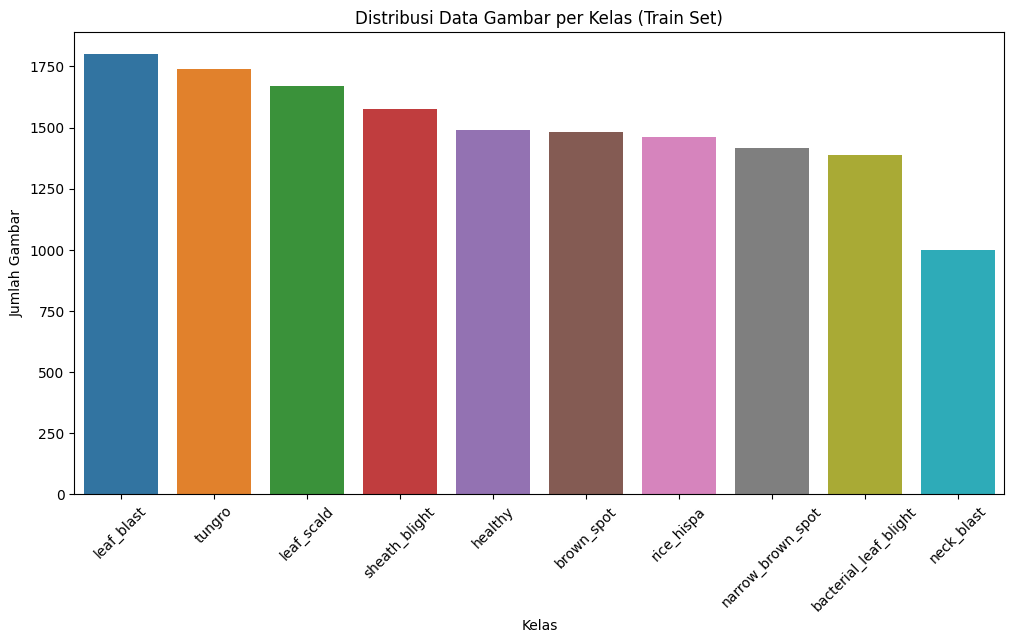

In [14]:
def plot_class_distribution(directory, title='Distribusi Data per Kelas'):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(image_files)

    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_classes)

    plt.figure(figsize=(12,6))
    sns.barplot(x=list(classes), y=list(counts))
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_dir, 'Distribusi Data Gambar per Kelas (Train Set)')

### Membuat folder baru untuk dataset train, val, dan test

In [ ]:
base_dir_final = '/kaggle/working/dataset_final'
train_dir_final = os.path.join(base_dir_final, 'train')
val_dir_final = os.path.join(base_dir_final, 'val')
test_dir_final = os.path.join(base_dir_final, 'test')

for d in [train_dir_final, val_dir_final, test_dir_final]:
    if not os.path.exists(d):
        os.makedirs(d)

### Menyalin file gambar ke folder train, val, dan test sesuai dataframe

In [ ]:
copy_files_to_dir(train_df, train_dir_final) 
copy_files_to_dir(val_df, val_dir_final) 
copy_files_to_dir(combined_test, test_dir_final)

### Mengganti nama folder label pada dataset menjadi diawali "rice_"

In [17]:
base_path = '/kaggle/working/dataset_final'
sets = ['train', 'val', 'test']

for subset in sets:
    subset_path = os.path.join(base_path, subset)
    for label in os.listdir(subset_path):
        old_path = os.path.join(subset_path, label)
        new_label = f"rice_{label}" if not label.startswith("rice_") else label
        new_path = os.path.join(subset_path, new_label)
        if os.path.isdir(old_path):
            os.rename(old_path, new_path)
            print(f"Folder '{label}' diubah menjadi '{new_label}'")

Folder 'leaf_scald' diubah menjadi 'rice_leaf_scald'
Folder 'tungro' diubah menjadi 'rice_tungro'
Folder 'leaf_blast' diubah menjadi 'rice_leaf_blast'
Folder 'brown_spot' diubah menjadi 'rice_brown_spot'
Folder 'bacterial_leaf_blight' diubah menjadi 'rice_bacterial_leaf_blight'
Folder 'rice_hispa' diubah menjadi 'rice_hispa'
Folder 'narrow_brown_spot' diubah menjadi 'rice_narrow_brown_spot'
Folder 'healthy' diubah menjadi 'rice_healthy'
Folder 'neck_blast' diubah menjadi 'rice_neck_blast'
Folder 'sheath_blight' diubah menjadi 'rice_sheath_blight'
Folder 'leaf_scald' diubah menjadi 'rice_leaf_scald'
Folder 'tungro' diubah menjadi 'rice_tungro'
Folder 'leaf_blast' diubah menjadi 'rice_leaf_blast'
Folder 'brown_spot' diubah menjadi 'rice_brown_spot'
Folder 'bacterial_leaf_blight' diubah menjadi 'rice_bacterial_leaf_blight'
Folder 'rice_hispa' diubah menjadi 'rice_hispa'
Folder 'narrow_brown_spot' diubah menjadi 'rice_narrow_brown_spot'
Folder 'healthy' diubah menjadi 'rice_healthy'
Folder

### Membuat data generator untuk train, val, dan test menggunakan ImageDataGenerator

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir_final = '/kaggle/working/dataset_final/train'
val_dir_final = '/kaggle/working/dataset_final/val'
test_dir_final = '/kaggle/working/dataset_final/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir_final, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=1337
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir_final, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir_final, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

print("\nClass indices from train_generator:")
print(train_generator.class_indices)

Found 17530 images belonging to 10 classes.
Found 7514 images belonging to 10 classes.
Found 5024 images belonging to 10 classes.

Class indices from train_generator:
{'rice_bacterial_leaf_blight': 0, 'rice_brown_spot': 1, 'rice_healthy': 2, 'rice_hispa': 3, 'rice_leaf_blast': 4, 'rice_leaf_scald': 5, 'rice_narrow_brown_spot': 6, 'rice_neck_blast': 7, 'rice_sheath_blight': 8, 'rice_tungro': 9}


### Menghitung bobot kelas (class weights) secara otomatis berdasarkan distribusi data training

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, (class_name, weight) in enumerate(zip(train_generator.class_indices.keys(), class_weights)):
    print(f"{class_name}: {weight:.3f}")

Class weights:
rice_bacterial_leaf_blight: 1.042
rice_brown_spot: 0.896
rice_healthy: 1.038
rice_hispa: 0.977
rice_leaf_blast: 0.762
rice_leaf_scald: 0.894
rice_narrow_brown_spot: 1.124
rice_neck_blast: 1.354
rice_sheath_blight: 0.845
rice_tungro: 1.439


# Modelling

### Memuat arsitektur MobileNetV2 sebagai feature extractor

In [20]:
mobnet = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
for layer in mobnet.layers:
    layer.trainable = False

I0000 00:00:1748969605.351708      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Membangun dan Melatih Model

In [21]:
model = tf.keras.models.Sequential([
    mobnet,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

history = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


I0000 00:00:1748969616.935045      90 service.cc:148] XLA service 0x7ced84001870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748969616.937111      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748969618.013974      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/548 ━━━━━━━━━━━━━━━━━━━━ 1:59:30 13s/step - accuracy: 0.1250 - loss: 3.8406

I0000 00:00:1748969622.512515      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 ━━━━━━━━━━━━━━━━━━━━ 439s 778ms/step - accuracy: 0.3410 - loss: 1.7987 - val_accuracy: 0.6242 - val_loss: 1.0858 - learning_rate: 0.0010
Epoch 2/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.5445 - loss: 1.1849 - val_accuracy: 0.6590 - val_loss: 0.9709 - learning_rate: 0.0010
Epoch 3/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 742ms/step - accuracy: 0.6056 - loss: 1.0102 - val_accuracy: 0.6839 - val_loss: 0.8668 - learning_rate: 0.0010
Epoch 4/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 740ms/step - accuracy: 0.6285 - loss: 0.9568 - val_accuracy: 0.6813 - val_loss: 0.8928 - learning_rate: 0.0010
Epoch 5/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 741ms/step - accuracy: 0.6441 - loss: 0.8925 - val_accuracy: 0.7031 - val_loss: 0.8014 - learning_rate: 0.0010
Epoch 6/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 401s 732ms/step - accuracy: 0.6584 - loss: 0.8496 - val_accuracy: 0.7034 - val_loss: 0.8047 - learning_rate: 0.0010
Epoch 7/35
548/548 ━━━━━━━━━━━━━━━━━━━━ 403s 735ms/step - accuracy: 0.6676 

### Menampilkan grafik akurasi dan loss selama training dan validasi

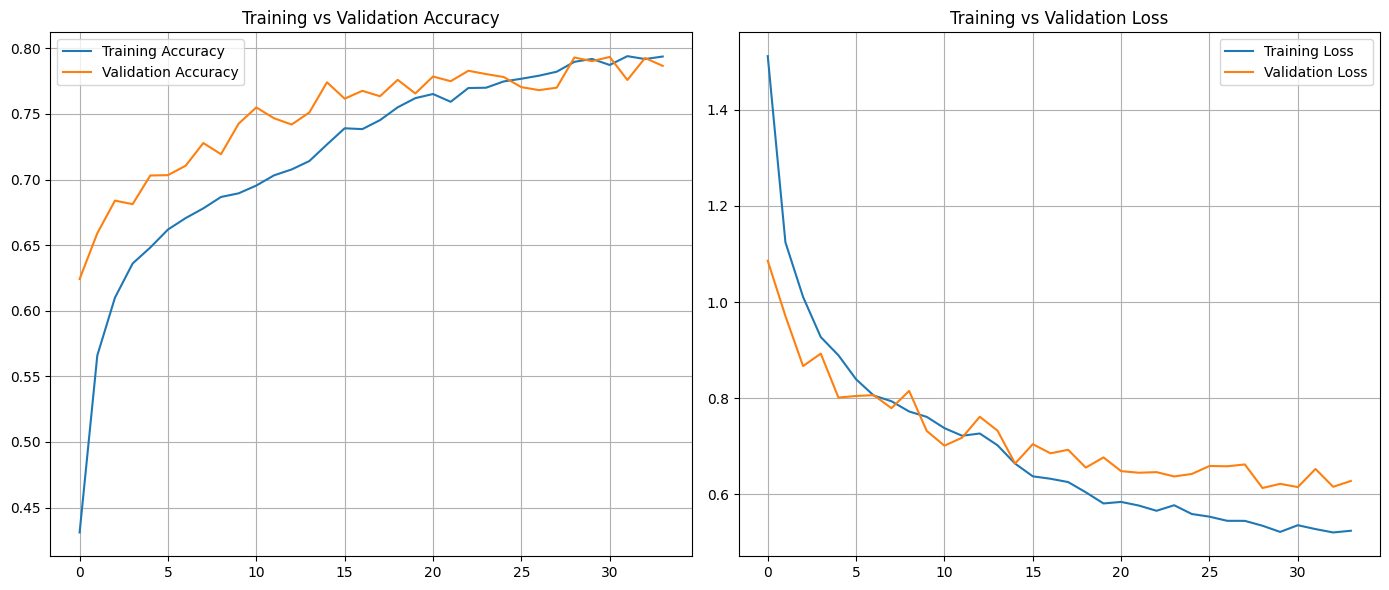

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi Model

### Mengevaluasi model pada data test

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 406ms/step - accuracy: 0.7667 - loss: 0.6934

Test Accuracy: 0.8175
Test Loss: 0.5430


### Menampilkan classification report dan visualisasi confusion matrix 

157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 417ms/step
📄 Classification Report:

                            precision    recall  f1-score   support

rice_bacterial_leaf_blight       0.95      0.79      0.86       556
           rice_brown_spot       0.68      0.72      0.70       609
              rice_healthy       0.98      0.85      0.91       538
                rice_hispa       0.92      0.97      0.95       388
           rice_leaf_blast       0.50      0.60      0.54       615
           rice_leaf_scald       0.84      0.86      0.85       578
    rice_narrow_brown_spot       0.71      0.82      0.76       519
           rice_neck_blast       1.00      1.00      1.00       421
        rice_sheath_blight       0.97      0.79      0.87       490
               rice_tungro       0.99      0.95      0.97       310

                  accuracy                           0.82      5024
                 macro avg       0.85      0.84      0.84      5024
              weighted avg       0.83      0

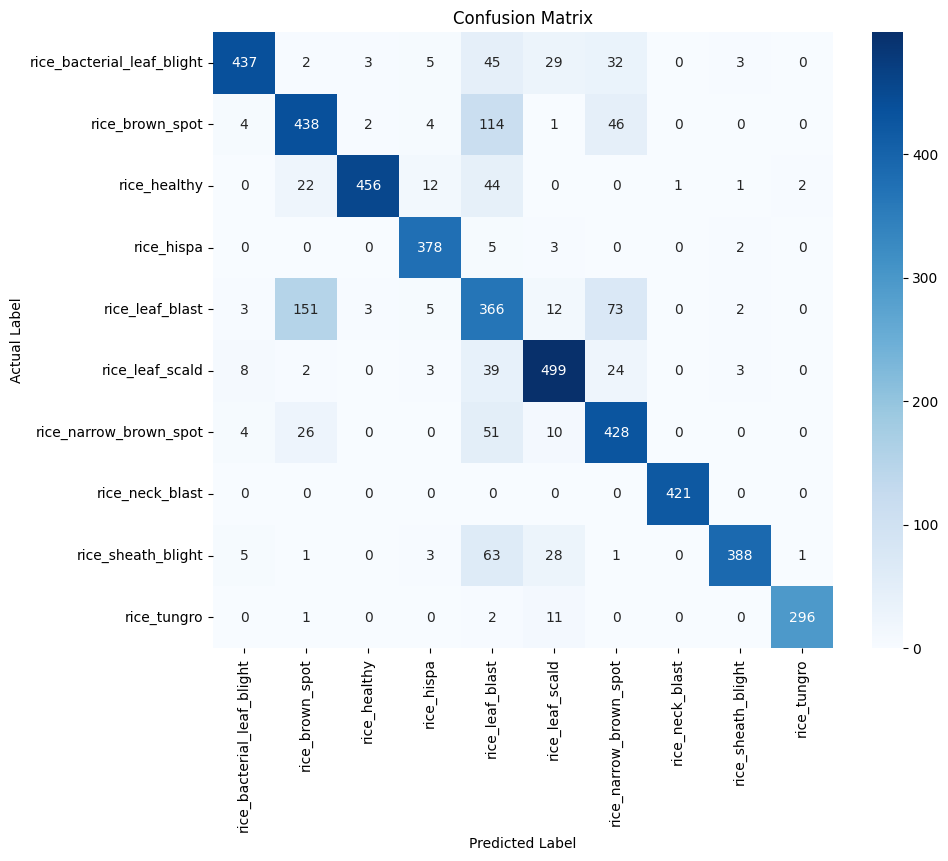

In [24]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("📄 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

### Menghapus folder sementara hasil preprocessing dan dataset yang sudah tidak diperlukan lagi

In [25]:
for folder in ['/kaggle/working/rice_leaf_data_standardized', '/kaggle/working/dataset_final']:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Folder '{folder}' berhasil dihapus.")
    else:
        print(f"Folder '{folder}' tidak ditemukan.")

Folder '/kaggle/working/rice_leaf_data_standardized' berhasil dihapus.
Folder '/kaggle/working/dataset_final' berhasil dihapus.


### Menyimpan model yang sudah dilatih ke dalam file model_padi.h5

In [26]:
model.save('/kaggle/working/model_padi.h5')
print("Model berhasil disimpan ke dalam file model_padi.h5")

Model berhasil disimpan ke dalam file model_padi.h5


### Mengekspor model yang sudah dilatih ke format TensorFlow.js

In [27]:
tfjs.converters.save_keras_model(model, '/kaggle/working/model_padi_tfjs')
print("Model berhasil diekspor ke format TensorFlow.js di folder '/kaggle/working/model_tfjs'")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil diekspor ke format TensorFlow.js di folder '/kaggle/working/model_tfjs'


# Inference 

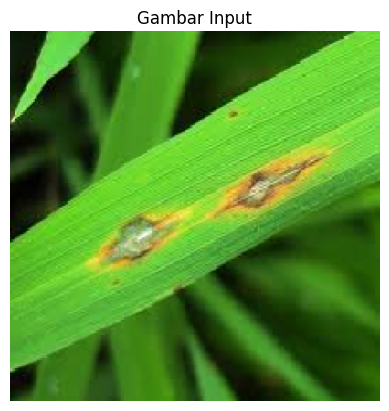

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi: rice_narrow_brown_spot
Confidence Score: 0.31


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

model = load_model('/kaggle/working/model_padi.h5')

img_path = '/kaggle/input/padi-test/padi-bercak.jpg'
img = load_img(img_path, target_size=(224, 224))  
img_array = img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0) 

plt.imshow(img)
plt.axis('off')
plt.title("Gambar Input")
plt.show()

predictions = model.predict(img_array)[0]
predicted_index = np.argmax(predictions)
confidence = predictions[predicted_index]

labels = list(train_generator.class_indices.keys())  
predicted_label = labels[predicted_index]

print(f"Prediksi: {predicted_label}")
print(f"Confidence Score: {confidence:.2f}")